## Import Libraries and Data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings                   #Ignore the warnings

warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [53]:
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.facecolor']='lightcyan'
plt.rcParams['figure.facecolor']='lightgoldenrodyellow'

In [4]:
filepath='D:\Data Science\Python\Project-5 Application Of Time Series Models'
df_ss = pd.read_excel(filepath+"\Superstore.xls")

## Preliminary Data Analysis and Preprocessing for the complete dataset:

In [5]:
df_ss.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
# View basic statistics of the dataset
df_ss.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [7]:
# Check for Null/ Missing values
df_ss.isnull().sum().sort_values(ascending=False).head()

Profit        0
City          0
Order ID      0
Order Date    0
Ship Date     0
dtype: int64

### Comments: 
* Sales and Profit seems to be of interest for understanding and forecasting
* No Null/Missing Data observed

# 1. Forecast Future Sales for Furniture

In [8]:
# Prepare Furniture Data
df_furniture = df_ss.loc[df_ss['Category'] == 'Furniture'].drop(columns=[c for c in df_ss.columns if c not in ['Category', 'Order Date','Sales']])

df_furniture=df_furniture.drop(columns=[c for c in df_furniture.columns if c not in ['Category', 'Order Date','Sales']])


In [9]:
# Check the length of time series, i.e the min and max date for which the data is available
print('From Data :',df_furniture['Order Date'].min())
print('To Date :',df_furniture['Order Date'].max())

From Data : 2014-01-06 00:00:00
To Date : 2017-12-30 00:00:00


### Comments:
Data is available for 4 years, from 2014 to 2017

In [10]:
df_furniture.head()

,Order Date,Category,Sales
0,2016-11-08,Furniture,261.9600
1,2016-11-08,Furniture,731.9400
3,2015-10-11,Furniture,957.5775
5,2014-06-09,Furniture,48.8600
10,2014-06-09,Furniture,1706.1840


### Indexing time-series data

In [11]:
# Make datatime index from the 'Order Date' column
df_furniture = df_furniture.set_index('Order Date')

In [12]:
df_furniture.sort_index().head()

,Category,Sales
Order Date,,
2014-01-06,Furniture,2573.820
2014-01-07,Furniture,76.728
2014-01-10,Furniture,51.940
2014-01-11,Furniture,9.940
2014-01-13,Furniture,545.940


In [16]:
# Cacluate average Sales by Month
df_f_month = df_furniture['Sales'].resample('MS').sum()
df_f_month.head()

Order Date
2014-01-01     6242.525
2014-02-01     1839.658
2014-03-01    14573.956
2014-04-01     7944.837
2014-05-01     6912.787
Freq: MS, Name: Sales, dtype: float64

### Furniture data time-series visualization

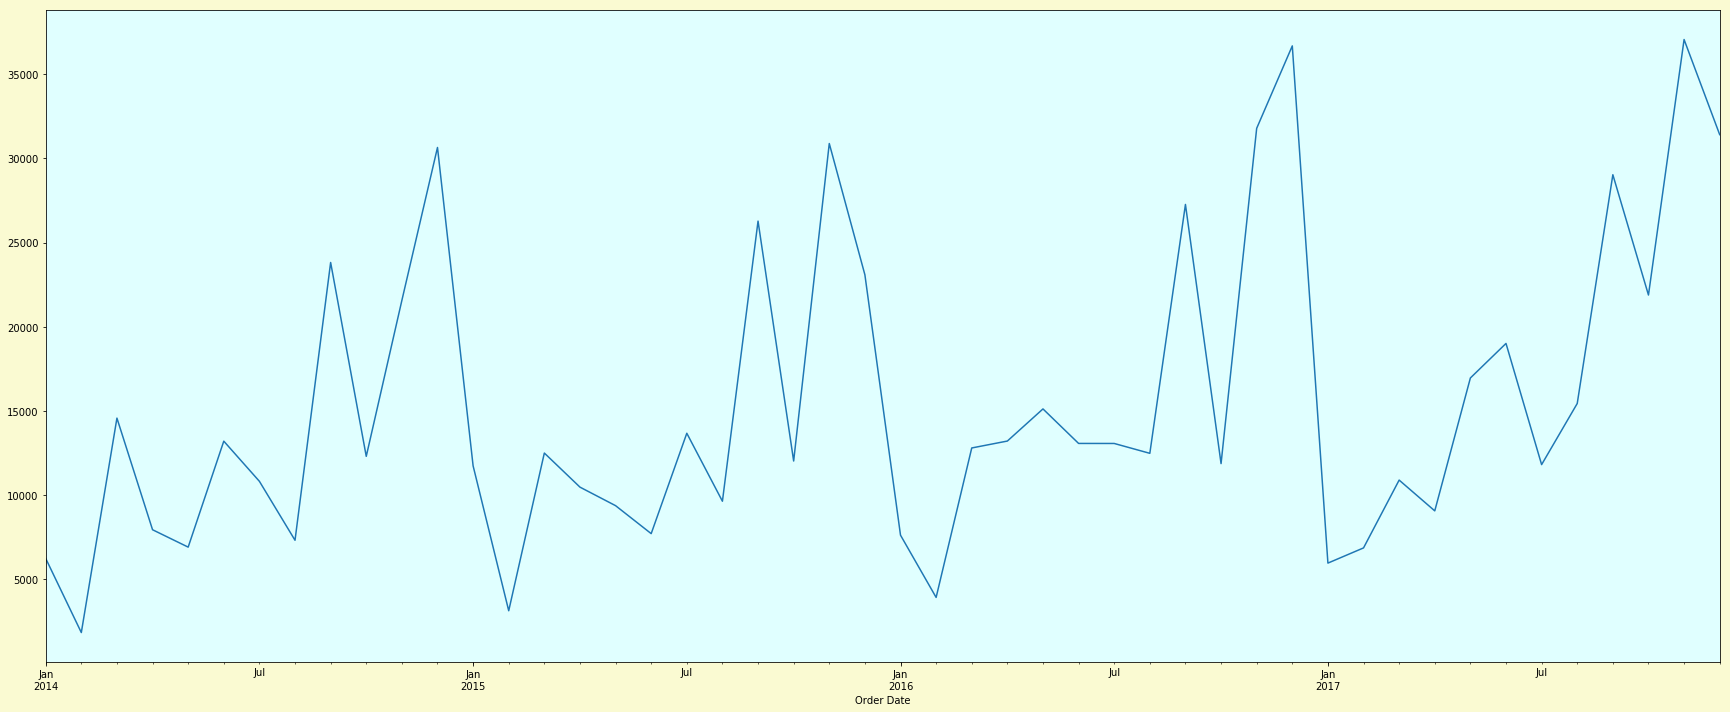

In [17]:
# fig = plt.figure()
# rect = fig.patch # a rectangle instance
# rect.set_facecolor('lightgoldenrodyellow')
# ax = fig.add_axes([0.1, 0.3, 0.4, 0.4])
# rect = ax.patch
# rect.set_facecolor('lightcyan')
df_f_month.plot(figsize=(30,12))
plt.show()

## Time Series forecasting with ARIMA Model

### Check Stationarity

In [18]:
# Function to print Adfuller Test Results
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts)
    print(ts_test)
    ts_test_output = pd.Series(ts_test[0:2], index=['Test Statistic','p-value'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [19]:
# Run Adfuller test for monthly data
TestStationaryAdfuller(df_f_month)

(-4.699026242828903, 8.450793985809654e-05, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 781.9861669712573)
Test Statistic         -4.699026
p-value                 0.000085
Critical Value (1%)    -3.577848
Critical Value (5%)    -2.925338
Critical Value (10%)   -2.600774
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


### Comment:
The dataset for average monthly sales of Furniture is <b>stationary</b>

### Check Seasonality in the data

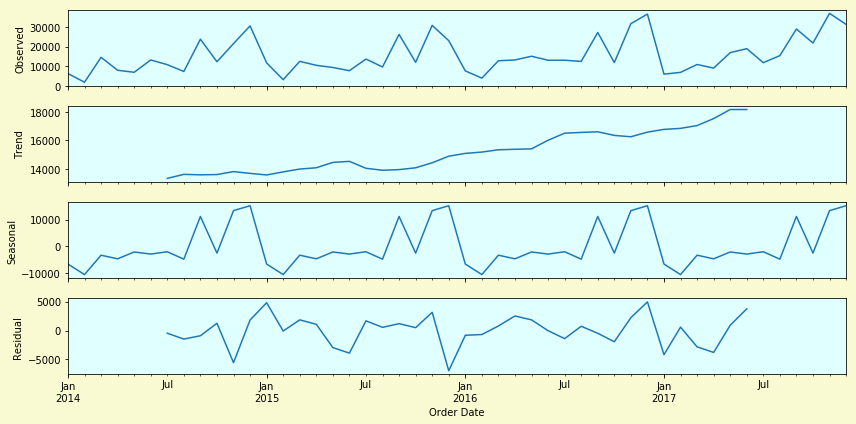

In [20]:
decomposition = sm.tsa.seasonal_decompose(df_f_month, model='additive')
decomposition.plot()
plt.show()

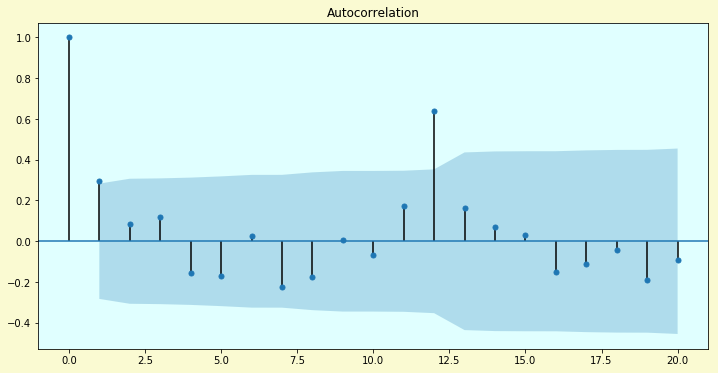

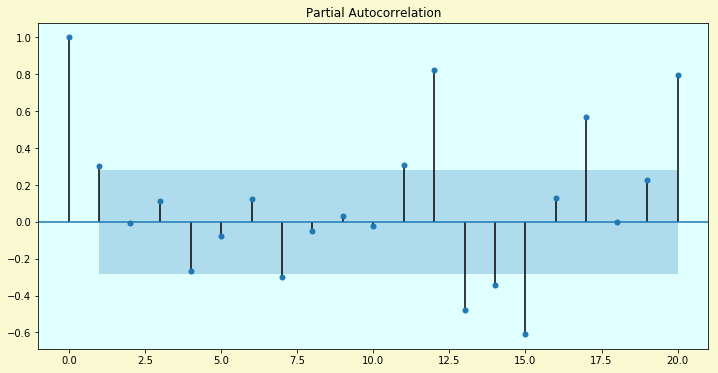

In [21]:
plot_acf(df_f_month,lags=20)
plt.show()
plot_pacf(df_f_month,lags=20)
plt.show()

### Grid Search for parameters for ARIMA

In [44]:
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
aic=[]
param_pqd=[]
param_PQDs=[]
param_aic=[]
model_par={}

In [45]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(df_f_month, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            param_pqd.append(param)
            param_PQDs.append(param_seasonal)
            param_aic.append(results.aic)
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


model_par={'param':param_pqd,'param_seasonal':param_PQDs, 'aic':param_aic}
aic_table=pd.DataFrame(data=model_par)
print('Below are the best parameters found:')
print(aic_table.sort_values(by='aic', ascending=True).iloc[0,:])

Below are the best parameters found:
param                 (1, 1, 1)
param_seasonal    (1, 1, 0, 12)
aic                     439.172
Name: 47, dtype: object


### Fitting the Model with the above parameters

In [46]:
model = sm.tsa.statespace.SARIMAX(df_f_month, order=(1,1,0), seasonal_order=(1,1,0,12), enforce_stationarity=False,
                                            enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -219.080
Date:                            Thu, 13 Jun 2019   AIC                            444.159
Time:                                    22:49:46   BIC                            447.432
Sample:                                01-01-2014   HQIC                           444.930
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4491      0.398     -1.129      0.259      -1.229       0.330
ar.S.L12      -0.4394      0.271   

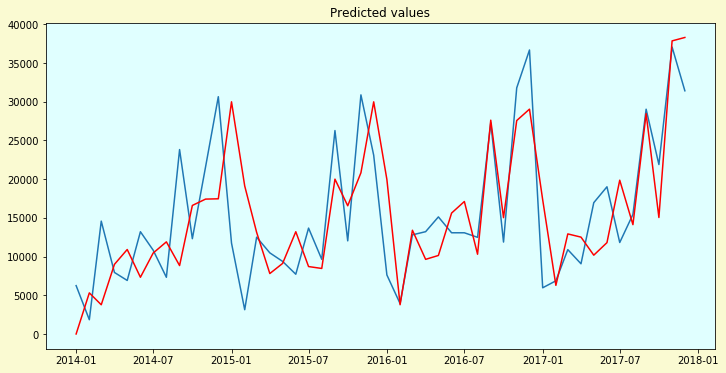

In [81]:
fitted_values=results.fittedvalues
plt.plot(df_f_month)
plt.plot(results.fittedvalues, color='red')
plt.title('Predicted values')
plt.show()

### Generate model diagnostics and investigate for any unusual behavior

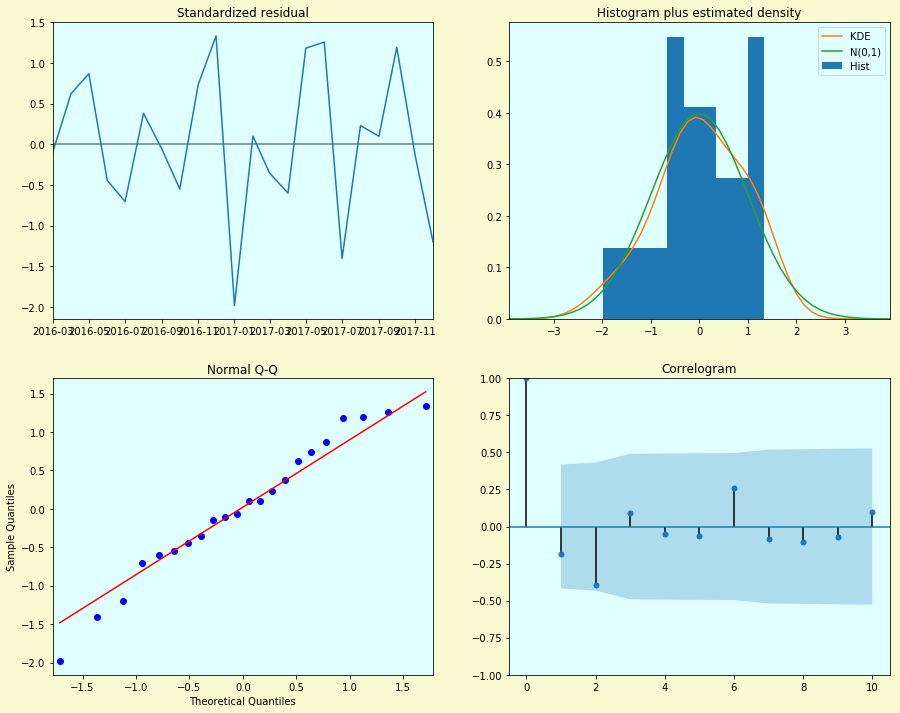

In [49]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Observations:

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

* So, these observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Validating the model forecasts
To validate the model results, we compare the actual sales with the predicted sales of the time series data starting from 2017/01/01 till the end of the data.

             lower Sales   upper Sales
Order Date                            
2017-01-01   6095.941929  28571.781847
2017-02-01  -4957.487637  17518.352281
2017-03-01   1684.754482  24160.594400
2017-04-01   1270.742105  23746.582023
2017-05-01  -1061.425064  21414.414855
2017-06-01    559.824356  23035.664274
2017-07-01   8623.687198  31099.527116
2017-08-01   2881.078971  25356.918889
2017-09-01  17224.959132  39700.799050
2017-10-01   3804.642903  26280.482821
2017-11-01  26614.973427  49090.813345
2017-12-01  27057.159092  49532.999010


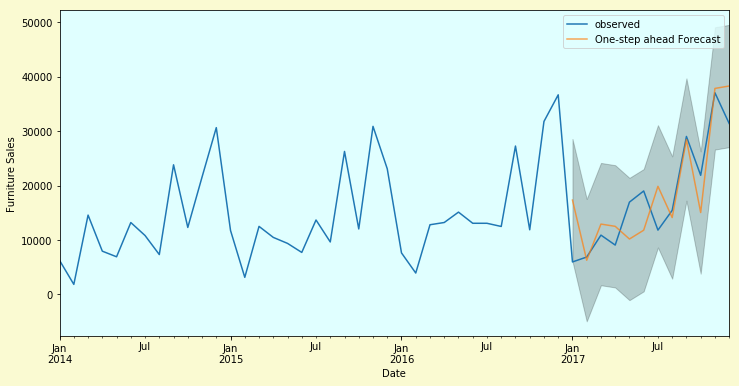

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = df_f_month['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Comments:

The above plot demonstrates that the predicted values alligns well with the true values capturing an upward seasonality. Now, we calculate the Mean Square Error of our predicted values wrt the orignal values.

### Calculate MSE and RMSE Values for the predicted values

In [55]:
sales_predicted = pred.predicted_mean
sales_true = df_f_month['2017-01-01':]
mse = ((sales_predicted - sales_true)**2).mean()
print('Mean Square Error is:', round(mse, 4))
print('Root Mean Square Error is:', np.sqrt(mse))

Mean Square Error is: 33774498.4345
Root Mean Square Error is: 5811.583126350834


### Future Forecasts

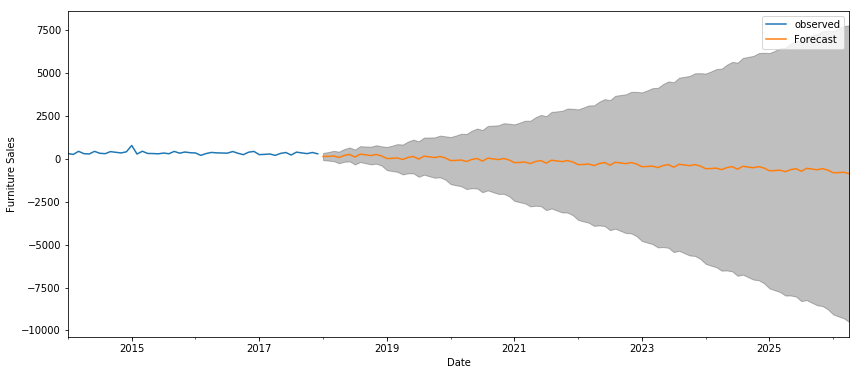

In [29]:
# Forecasting the future (out of sample) values.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df_f_month.plot(label='observed', figsize=(14, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Comments

The confidence interval is increasing as we move further into the future. The model becomes less confident in predicting the values as we move ahead.

# 2. Comparing Sales of Furniture against Sales of Office Supplies

In [61]:
#Prepare Data for Furniture sales and Office Supplies Sales

furniture = df_ss.loc[df_ss['Category'] == 'Furniture']
office = df_ss.loc[df_ss['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [62]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

# Summarize to Monthly Average Sales for Both
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

In [63]:
#Meger both data for Furniture and Office Supplies into one
store = furniture.merge(office, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furniture Sales', 'Sales_y': 'Office Sales'}, inplace=True)
store.head()

,Order Date,Furniture Sales,Office Sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


### Visualize Time Series For Furniture and Office Supplies

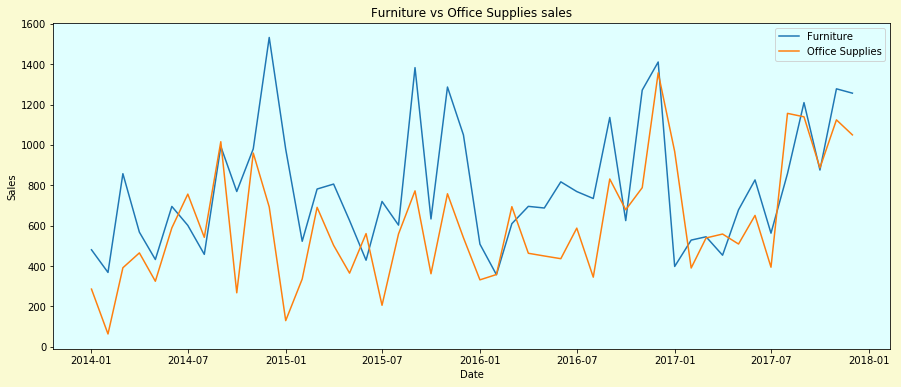

In [64]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furniture Sales'], label='Furniture')
plt.plot(store['Order Date'], store['Office Sales'], label='Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales')
plt.legend()

## Observations

* The above plot clearly shows that both furniture and office supplies exhibit similar seasonality component.
* The sales are generally low at the beginning of every year as evident from decreasing line slope at the onset of year 2014, 2015, 2016 etc.
* Also, monthly average sales of furniture is higher than that of office supplies. It's probably because cost of furniture is much more as compared to office utilities.
* But there are few instances in the time series where office supply sales surpass furniture. It is mainly in Mid 2014 for the first time in the dataset.

# 3. Forecast Future Profits for the store

In [65]:
# Creating Time series data
ts=df_ss.groupby('Order Date')[['Row ID']].sum()
ts=ts.rename(columns={'Row ID':'Profit'})

In [66]:
# Total Monthly Profits
ts=ts.resample('MS').sum()

In [67]:
ts.head()

,Profit
Order Date,
2014-01-01,346176
2014-02-01,272235
2014-03-01,871575
2014-04-01,690625
2014-05-01,611708


In [69]:
# Check for Null/Missing Data
ts.isnull().sum()

Profit    0
dtype: int64

## Visualize The Timeseries

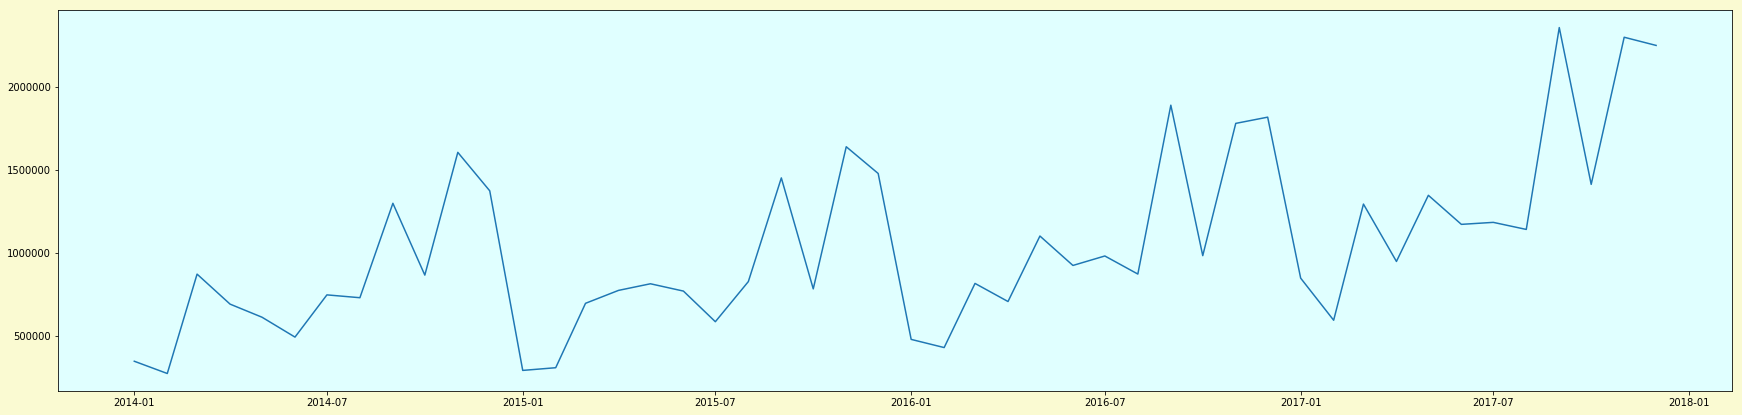

In [70]:
fig= plt.figure(figsize=(30,7))
plt.plot(ts)

### Comments:
* We observe a  general upward trend for profit
* End of year usually shows a seasonal peak in profit

## Checking the stationarity of time series

In [71]:
TestStationaryAdfuller(ts.T.squeeze())

(-3.8541122706786575, 0.002399746624981488, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 1078.1662763787353)
Test Statistic         -3.854112
p-value                 0.002400
Critical Value (1%)    -3.577848
Critical Value (5%)    -2.925338
Critical Value (10%)   -2.600774
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


## Taking Log of Data To Smoothen the profit plot

In [72]:
ts_log=np.log(ts)

## Decompose the Data to Observe properties of the time series

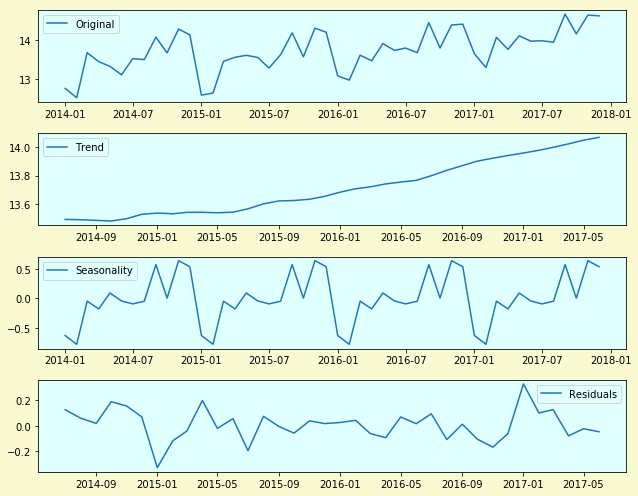

In [73]:
decomposition = sm.tsa.seasonal_decompose(ts_log.iloc[:,0],freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig= plt.figure(figsize=(9,7))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

###Checking stationarity of the decomposed data

In [75]:
ts_log_decompose = pd.DataFrame(residual)
ts_log_decompose.dropna(inplace=True)
TestStationaryAdfuller(ts_log_decompose.T.squeeze())

(-5.29446844550398, 5.621982865769659e-06, 2, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, -39.69959857932349)
Test Statistic         -5.294468
p-value                 0.000006
Critical Value (1%)    -3.646135
Critical Value (5%)    -2.954127
Critical Value (10%)   -2.615968
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


* <b>Observation : </b> Now the test statistic is better than the original data and therefore after removing seasonality and trend we have a better stationary time series

## Plot the ACF andPCF for the data

<Figure size 864x648 with 0 Axes>

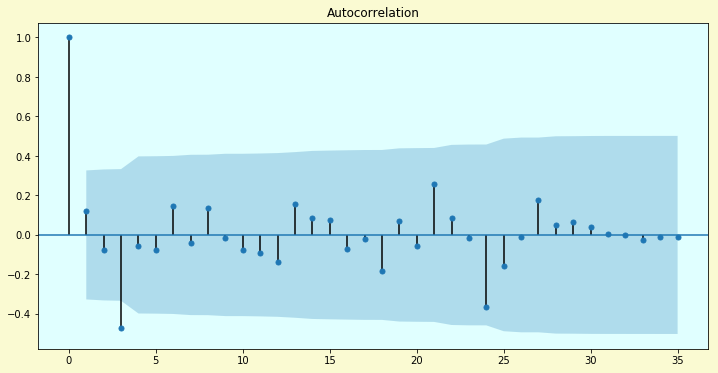

In [78]:
fig2=plt.figure(figsize=(12,9))
plot_acf(ts_log_decompose,lags=35)
plt.show()

<Figure size 864x648 with 0 Axes>

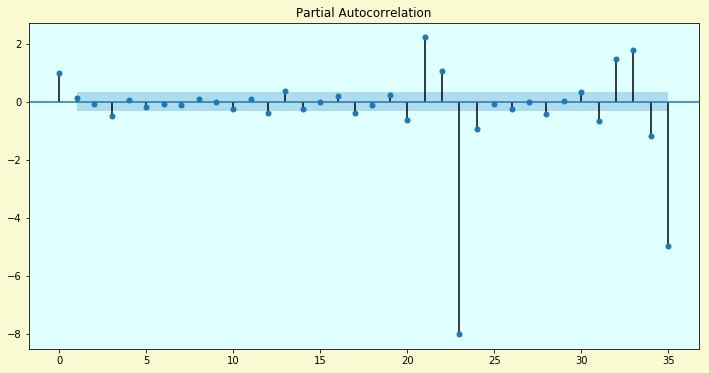

In [79]:
fig2=plt.figure(figsize=(12,9))
plot_pacf(ts_log_decompose,lags=35)
plt.show()

### Grid Search For ARMA parameters

In [93]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

param_pqd=[]
param_PQDs=[]
param_aic=[]
model_par={}

In [94]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(ts_log_decompose, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            param_pqd.append(param)
            param_PQDs.append(param_seasonal)
            param_aic.append(results.aic)
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
model_par={'param':param_pqd,'param_seasonal':param_PQDs, 'aic':param_aic}
aic_table=pd.DataFrame(data=model_par)
print('Below are the best parameters found:')
print(aic_table.sort_values(by='aic', ascending=True).iloc[0,:])

Below are the best parameters found:
param                 (0, 1, 4)
param_seasonal    (2, 0, 0, 12)
aic                    -330.158
Name: 61, dtype: object


## Fit the model using best parameters found above

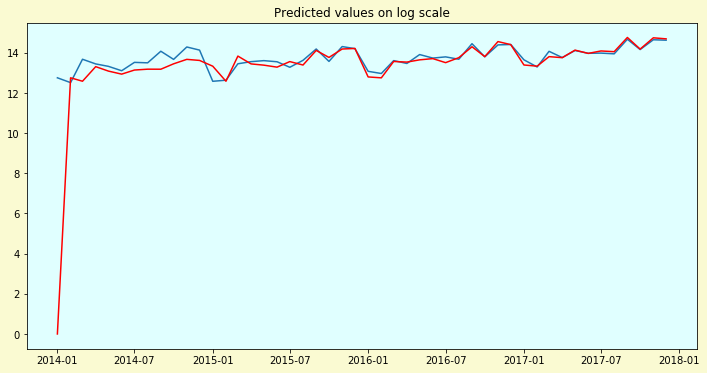

In [95]:
model = SARIMAX(ts_log, trend='n', order=(0,1,4), seasonal_order=(2,0,0,12),enforce_invertibility=False)
results = model.fit(disp=-1) 
fitted_values=results.fittedvalues
plt.plot(ts_log)
plt.plot(results.fittedvalues, color='red')
plt.title('Predicted values on log scale')
plt.show()

## Plot The Predictions using the model after removing the Log Transformation

Text(0.5, 1.0, 'RMSE: 254007.7459')

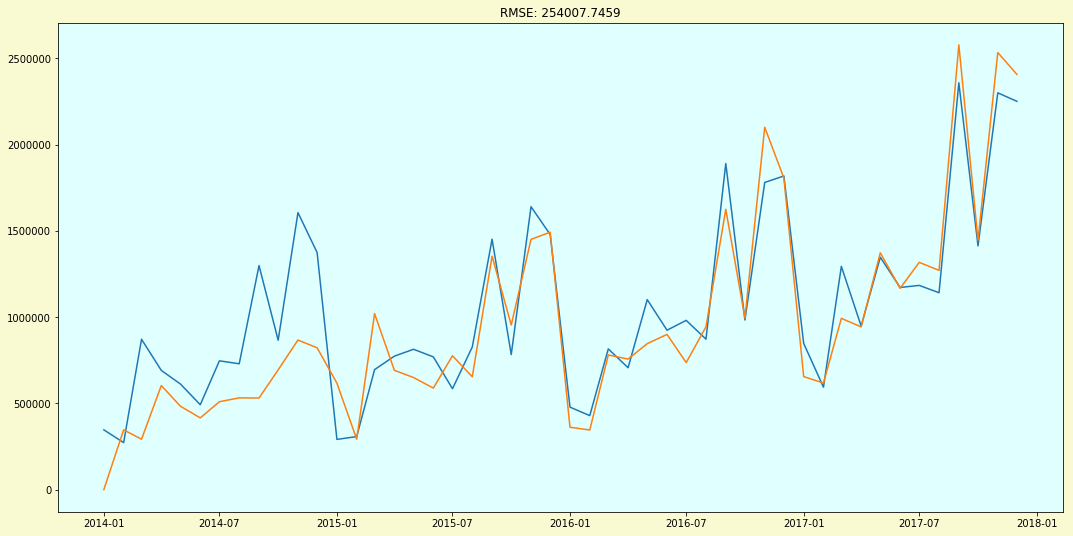

In [96]:
predictions_SARIMAX = pd.Series(results.fittedvalues, copy=True)

predictions_SARIMAX1 = np.exp(predictions_SARIMAX)
fig=plt.figure(figsize=(18,9))
plt.plot(ts)
plt.plot(predictions_SARIMAX1)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_SARIMAX1-ts.iloc[:,0])**2)/len(ts)))

## Generate model Diagnostics

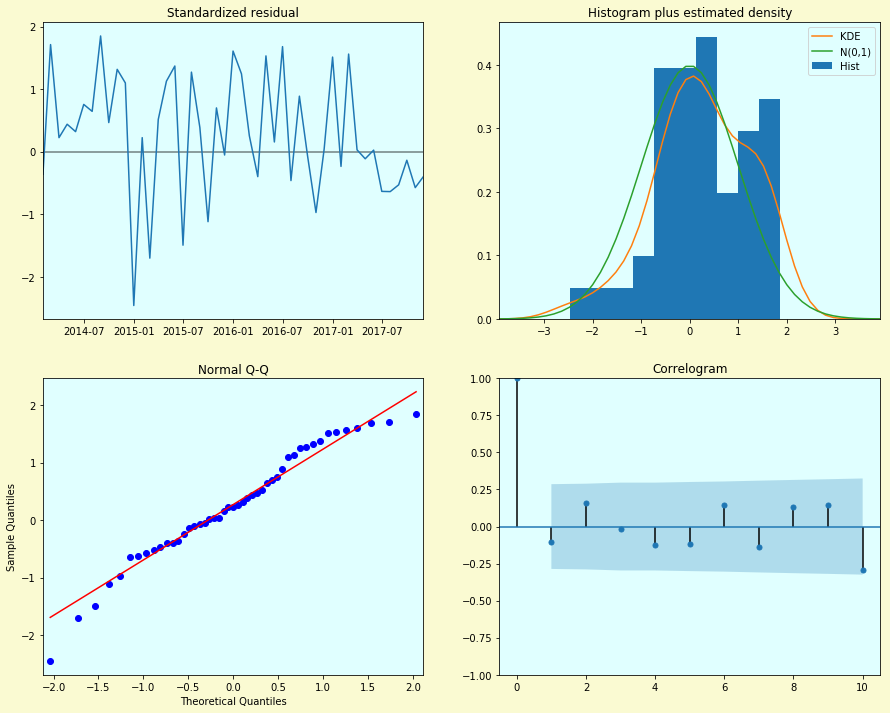

In [97]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Observations:
* In the top right plot, the residuals are normally distributed. However, this could still be better.
* From the qq-plot, residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
* So, our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

## Forecasting Profit
The model is then used to predict the future data. I have taken 1 year worth of available data(i.e. data for 2014) and used it to forecast trend for dates after that. RMSE is used to measure the accuracy of prediction

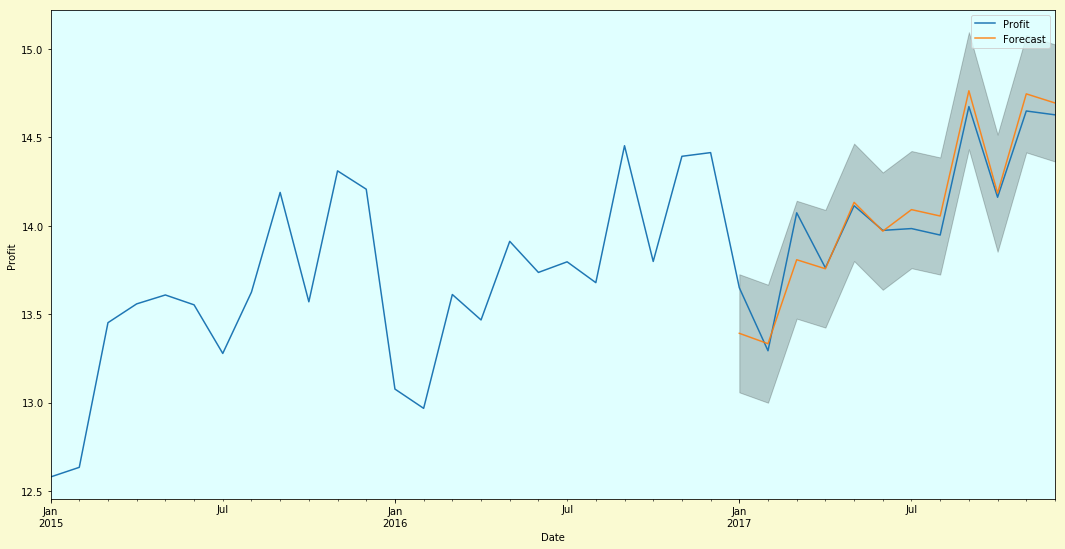

RMSE: 0.0619


In [98]:
pred = results.get_prediction(36)
pred_ci = pred.conf_int()
ax = ts_log['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(18, 9))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Profit')
plt.legend()
plt.show()
print('RMSE: %.4f'% np.sqrt(sum((pred.predicted_mean-ts_log.iloc[36:,0])**2)/len(ts)))

In [27]:
plt.rcParams.clear()